In [24]:
import pymongo
from pymongo import MongoClient

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

import getpass
import base64

import xgboost as xgb

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, log_loss, f1_score
from sklearn.base import BaseEstimator
from sklearn.svm import SVC

%matplotlib inline

# connecting to the database

In [2]:
client = MongoClient('localhost:27017')
db = client.arXivDB
db.users.count()

9

In [3]:
def cleaner(doc, stem=False):
    '''Function to clean the text data and prep for further analysis'''
    doc = doc.lower() # turn text to lowercase

    stops = set(stopwords.words("english"))       # Creating a set of Stopwords
    p_stemmer = PorterStemmer()                   # Creating the stemmer model

    doc = re.sub(r"quantum", '', doc)           # removing the word quantum (duh)
    doc = re.sub(r"physics", '', doc)           # removing the word physics (duh)
    doc = re.sub(r"state", '', doc)           # removing the word state (duh)
    doc = re.sub(r'\$.*?\$', 'latexinlineformula', doc) # replacing latex inline formula
    doc = re.sub(r'\\n', ' ', doc) # removing new line character
    doc = re.sub(r'\\\\\"', '', doc)             # removing german double dotted letters
    doc = re.sub(r"</?\w+[^>]*>", '', doc)      # removing html tags
    doc = re.sub("[^a-zA-Z]", ' ', doc)    # removing anythin other alpha-numerical char's and @ and !

    doc = doc.split()                          # Splits the data into individual words 
    doc = [w for w in doc if not w in stops and len(w) > 3]   # Removes stopwords and short length words
    if stem:
        doc = [p_stemmer.stem(i) for i in doc]     # Stemming (reducing words to their root)
    if not len(doc):                            # dealing with comments that are all emojis, stop words or other languages
        doc = ['emptystring']
    # print('text cleaning done!')
    return ' '.join(doc)

In [4]:
class feature_stacker(BaseEstimator):
    """Stacks several transformer objects to yield concatenated features.
    Similar to pipeline, a list of tuples ``(name, estimator)`` is passed
    to the constructor.
    """
    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def get_feature_names(self):
        feature_names = []
        for name, trans in self.transformer_list:
            feature_names.extend(trans.get_feature_names())
        feature_names = [" ".join(w) if isinstance(w, tuple) else w
                            for w in feature_names]
        return np.array(feature_names)

    def fit(self, X, y=None):
        for name, trans in self.transformer_list:
            trans.fit(X, y)
        return self

    def transform(self, X):
        features = []
        for name, trans in self.transformer_list:
            features.append(trans.transform(X))
        issparse = [sparse.issparse(f) for f in features]
        if np.any(issparse):
            features = sparse.hstack(features).tocsr()
        else:
            features = np.hstack(features)
        return features

    def get_params(self, deep=True):
        if not deep:
            return super(feature_stacker, self).get_params(deep=False)
        else:
            out = dict(self.transformer_list)
            for name, trans in self.transformer_list:
                for key, value in trans.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [5]:
vectorizer_word = TfidfVectorizer(lowercase=False,
                                 analyzer=u'word',
                                 ngram_range=(1, 3),
                                 stop_words='english',
                                 binary=False,
                                 norm=u'l2', 
                                 use_idf=True, 
                                 smooth_idf=True, 
                                 sublinear_tf=True,
                                 min_df=3)

In [6]:
vectorizer_char = TfidfVectorizer(lowercase=False,
                                 analyzer=u'char',
                                 ngram_range=(1, 5),
                                 stop_words='english',
                                 binary=False,
                                 norm=u'l2', 
                                 use_idf=True, 
                                 smooth_idf=True, 
                                 sublinear_tf=True)

In [7]:
ft = feature_stacker([
                      ("words", vectorizer_word)])

In [8]:
select = SelectPercentile(score_func=chi2, percentile=1)

## logging in

In [9]:
while True:
    username = input('username: ').lower()
    user = list(db.users.find({'username': username}))
    if not user:
        print('the username doesnt exist, try again')
        user = None
    else:
        pin = base64.b64encode(bytes(str(getpass.getpass('pin: ')), encoding="UTF-8"))
        if not user[0]['pin']==pin:
            print('pin is incorrect, try again')
            user = None
        else:
            break

username: amir
pin: ········


In [10]:
query_results = list(db.likes.find({'user_id':user[0]['_id']}, {'paper_id':1, '_id':0, 'like':1}))
mypaper_ids = [d['paper_id'] for d in query_results]
mylikes = [d['like'] for d in query_results]

In [11]:
documents = [cleaner(' '.join([d['title'], d['summary']]), stem=True) for d in db.arXivfeeds.find(
                    {'_id': {'$in': mypaper_ids}}, {'_id':0, 'title':1, 'summary':1}
                )]

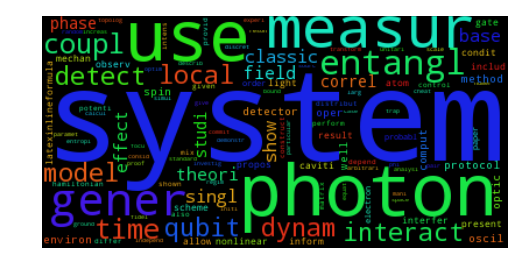

In [12]:
text = ' '.join([d for (d,l) in zip(documents,mylikes) if l])

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('wordCloud.png')

In [13]:
le = LabelEncoder()
le.fit(mylikes)
Y = le.transform(mylikes) 

In [14]:
ft.fit(documents)
X = ft.transform(documents)
select.fit(X, Y)
X = select.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=.80)

In [15]:
X.shape

(609, 25)

In [16]:
names = ft.get_feature_names()
names[select.get_support()]

array(['bind', 'bright', 'detector', 'discret time', 'discret time walk',
       'dynam local', 'imposs', 'intens', 'interfer experi',
       'interfer pattern', 'linearli', 'local measur', 'measur base',
       'momentum space', 'nonclass', 'nonlinear interact', 'optomechan',
       'perform use', 'photon crystal', 'photon interfer', 'proof',
       'qubit coupl', 'reaction', 'uncondit secur', 'world'], 
      dtype='<U56')

In [100]:
clf = SVC(C=1, 
          kernel='rbf', 
          degree=2, 
          gamma='auto', 
          coef0=0.0, 
          shrinking=True, 
          probability=True, 
          tol=1e-5, 
          cache_size=200, 
          class_weight='balanced', 
          verbose=True, 
          max_iter=1e3, 
          decision_function_shape=None, 
          random_state=None)
clf.fit(X_train, y_train)
pred = clf.predict_proba(X_test)

[LibSVM]

In [17]:
##################
#     XGBoost
##################

dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "max_depth": 7,
    "eval_metric": "logloss",
    "eta": 0.1,
    "silent": 1,
    "alpha": 3,
}
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
clf = xgb.train(params, dtrain, 30, evals=watchlist, verbose_eval=True)
pred = clf.predict(xgb.DMatrix(X_test))

[0]	train-logloss:0.620809	eval-logloss:0.643634
[1]	train-logloss:0.561512	eval-logloss:0.605075
[2]	train-logloss:0.512208	eval-logloss:0.574384
[3]	train-logloss:0.470711	eval-logloss:0.548544
[4]	train-logloss:0.435583	eval-logloss:0.527986
[5]	train-logloss:0.405649	eval-logloss:0.511823
[6]	train-logloss:0.380023	eval-logloss:0.499037
[7]	train-logloss:0.358017	eval-logloss:0.489291
[8]	train-logloss:0.33904	eval-logloss:0.481795
[9]	train-logloss:0.322662	eval-logloss:0.476305
[10]	train-logloss:0.308511	eval-logloss:0.472632
[11]	train-logloss:0.296248	eval-logloss:0.470202
[12]	train-logloss:0.28563	eval-logloss:0.468934
[13]	train-logloss:0.276436	eval-logloss:0.468627
[14]	train-logloss:0.268472	eval-logloss:0.469238
[15]	train-logloss:0.261569	eval-logloss:0.470363
[16]	train-logloss:0.255593	eval-logloss:0.472171
[17]	train-logloss:0.250422	eval-logloss:0.474333
[18]	train-logloss:0.245943	eval-logloss:0.476837
[19]	train-logloss:0.242079	eval-logloss:0.47954
[20]	train-lo

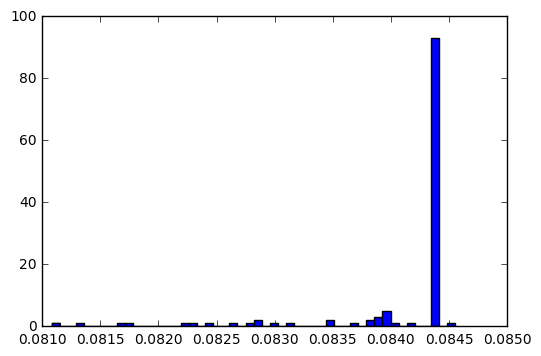

In [101]:
a = plt.hist(pred[:,1], bins=50)

In [103]:
print('confusion matrix:')
print(confusion_matrix(y_test, (pred<0.0842)[:,1]))

confusion matrix:
[[86 13]
 [ 8 15]]


In [19]:
num_papers_toshow = 20
test_documents = ['___'.join([d['title'], d['summary']]) for d in db.arXivfeeds.aggregate([
            {"$sample": {'size': num_papers_toshow}}
        ])]

In [20]:
test_X = ft.transform([cleaner(d) for d in test_documents])
test_X = select.transform(test_X)
pred = clf.predict(xgb.DMatrix(test_X))

In [21]:
test_documents = [x for (y,x) in sorted(zip(pred, test_documents))]
pred = np.sort(pred)

In [22]:
for j in range(len(pred)):
    print(pred[j])
    print(test_documents[j].split('___')[0])

0.0784138
(Nearly) optimal P-values for all Bell inequalities
0.0784138
Entanglement Trapping in Structured Environments
0.0784138
Feedback Control of Two-mode Output Entanglement and Steering in Cavity
  Optomechanics
0.0784138
Fuzziness in Quantum Mechanics
0.0784138
How come the Correlations?
0.0784138
Knowing "where the photons have been"
0.0784138
Long range order in non-equilibrium interacting quantum spin chains
0.0784138
Mapping of Euclidean resonance on static resonant tunneling
0.0784138
Non-Markovian dynamics in atom-laser outcoupling from a double-well
  Bose-Einstein condensate
0.0784138
Nonadditivity of Bipartite Distillable Entanglement follows from
  Conjecture on Bound Entangled Werner States
0.0784138
Operation Time of Quantum Gates
0.0784138
Polarization Entangled W State using Parametric Down-Conversion
0.0784138
QED processes beyond the Aharonov-Bohm effect
0.0784138
Quantum Chaos & Quantum Computers
0.0784138
Quantum coherence versus quantum discord in two coupled